In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score

Step 0: load our data

In [ ]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MSc thesis/processed_data/metadata/fully_concatenated_data.csv", lineterminator='\n')

In [ ]:
# List of image and text feature columns to keep
image_columns = [f'image_{i}' for i in range(0, 2049)]
text_columns = [f'text_{i}' for i in range(0, 768)]

# Additional columns you want to keep
additional_columns_to_keep = ['like_count', 'comment_count', 'post_id', 'Followers', 'Username', 'Followees', 'Posts',
                              'Year', 'Month', 'Day of Week (String)', 'Hour', 'Is_English', 'Image_Count', 'Sponsorship label', 'is_video']

# Combine both lists of columns to keep
columns_to_keep = additional_columns_to_keep + text_columns + image_columns

# Drop all columns except those specified in columns_to_keep
columns_to_drop = [col for col in data.columns if col not in columns_to_keep]

# Drop the unwanted columns from the dataframe
data_2 = data.drop(columns=columns_to_drop)


# Maybe don't delete category and detected languages
# Same with comments disabled and video
# potential columns to add or not:
#'comments_disabled',
#'is_video'
# Category
data_2.head(10)

,Username,post_id,like_count,comment_count,is_video,Sponsorship label,Followers,Followees,Posts,Year,...,text_758,text_759,text_760,text_761,text_762,text_763,text_764,text_765,text_766,text_767
0,00_rocketgirl,1354915397698488656,293,6,False,0,6453,710,1059,2016,...,-0.155746,-0.017703,-0.091135,0.058261,0.159358,0.032952,-0.012526,-0.204870,0.062999,0.075272
1,00_rocketgirl,1666974101448132749,73,2,False,0,6453,710,1059,2017,...,-0.247792,0.015757,-0.037442,-0.018389,0.203054,0.074983,0.049237,-0.213263,-0.012400,0.147600
2,00_rocketgirl,1768273356099895999,164,4,False,0,6453,710,1059,2018,...,-0.089539,-0.097885,-0.226008,0.053440,0.047846,0.004013,-0.182280,-0.174142,0.094179,0.080168
3,00_rocketgirl,1770557472379860655,474,18,False,0,6453,710,1059,2018,...,-0.215643,-0.101936,-0.123704,0.029802,0.113963,0.098773,-0.108283,-0.082098,0.045219,0.057346
4,00_rocketgirl,1899586748141399903,116,2,False,0,6453,710,1059,2018,...,-0.112963,-0.036261,-0.078814,0.114615,0.149342,0.011751,-0.150317,-0.156846,0.141513,0.093924
5,0720_b,1828882589862019412,1835,13,False,0,31521,2202,601,2018,...,0.013015,-0.100801,-0.067726,0.076079,0.248161,0.093687,-0.052417,-0.504811,0.080545,-0.086281
6,0720_b,1996580229074923796,1170,2,False,0,31521,2202,601,2019,...,0.027090,-0.154764,-0.085396,0.070190,0.285331,0.098012,-0.022090,-0.441710,0.055267,-0.116288
7,0720_b,2021587997624266181,820,2,False,0,31521,2202,601,2019,...,0.043861,-0.152151,-0.037170,0.045965,0.204610,0.092008,-0.048374,-0.509754,0.074065,-0.092127
8,0720_b,2021587997624266181,820,2,False,0,31521,2202,601,2019,...,0.043861,-0.152151,-0.037170,0.045965,0.204610,0.092008,-0.048374,-0.509754,0.074065,-0.092127
9,0hkris,1514786978688118458,269,0,False,0,12630,7069,261,2017,...,-0.147682,-0.036988,-0.208915,0.104713,0.120187,0.093342,0.097392,-0.009471,0.012900,0.064740


In [ ]:
data_2['Is_English'].value_counts()

Is_English
True     164872
False     31307
Name: count, dtype: int64

In [ ]:
# Filter the DataFrame to keep only observations where 'Is_English' is True
data_2 = data_2[data_2['Is_English'] == True]

In [ ]:
print(len(data_2))

164872


In [ ]:
# Filter image count to 10 or less, which is what is realistic in the industry
data_2 = data_2[data_2['Image_Count'] <= 1]

# Columns to one-hot encode
columns_to_encode = ['Year', 'Month', 'Hour', 'Day of Week (String)', 'Image_Count']

# Apply one-hot encoding
data_2 = pd.get_dummies(data_2, columns=columns_to_encode)

# Find the new one-hot encoded columns
encoded_columns = data_2.columns[data_2.columns.str.startswith(tuple(columns_to_encode))]

# Convert only the new one-hot encoded columns and boolean columns to int
data_2[encoded_columns] = data_2[encoded_columns].astype(int)

# Convert English column to integer
data_2['Is_English'] = data_2['Is_English'].astype(int)
data_2['is_video'] = data_2['is_video'].astype(int)
data_2['Sponsorship label'] = data_2['Sponsorship label'].astype(int)

Step 1: group and split the data by post_id

Define a popularity variable

In [ ]:
# Set the engagement rate variable
data_2['popularity'] = (((data_2['like_count'] + data_2['comment_count'])/data_2['Followers']))

Let's split the data!

In [ ]:
# Define the number of iterations and an array to store accuracies
n_iterations = 7
accuracies = []

for seed in range(n_iterations):
    print(f"Iteration {seed+1}")

    # Split users into training and temporary sets with a new seed each time
    train_users, temp_users = train_test_split(data_2['Username'].unique(), test_size=0.2, random_state=seed)
    val_users, test_users = train_test_split(temp_users, test_size=0.5, random_state=seed)

    # Assign posts to training, validation, and test sets
    train_data = data_2[data_2['Username'].isin(train_users)]
    val_data = data_2[data_2['Username'].isin(val_users)]
    test_data = data_2[data_2['Username'].isin(test_users)]

    # Normalize the selected features
    columns_to_normalize = ['Followers', 'Followees', 'Posts']
    scaler = StandardScaler().fit(train_data[columns_to_normalize])
    train_data.loc[:, columns_to_normalize] = scaler.transform(train_data[columns_to_normalize])
    val_data.loc[:, columns_to_normalize] = scaler.transform(val_data[columns_to_normalize])
    test_data.loc[:, columns_to_normalize] = scaler.transform(test_data[columns_to_normalize])

    # Calculate the median popularity rate for each dataset
    median_popularity_rate_train = train_data['popularity'].quantile(0.5)
    train_data.loc[:, 'popularity'] = (train_data['popularity'] > median_popularity_rate_train).astype(int)
    median_popularity_rate_val = val_data['popularity'].quantile(0.5)
    val_data.loc[:, 'popularity'] = (val_data['popularity'] > median_popularity_rate_val).astype(int)
    median_popularity_rate_test = test_data['popularity'].quantile(0.5)
    test_data.loc[:, 'popularity'] = (test_data['popularity'] > median_popularity_rate_test).astype(int)

    # Prepare data for XGBoost
    X_train = train_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username'], axis=1)
    y_train = train_data['popularity']
    X_val = val_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username'], axis=1)
    y_val = val_data['popularity']
    X_test = test_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username'], axis=1)
    y_test = test_data['popularity']

    # Convert datasets into DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Define XGBoost model parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'error',
        'alpha': 0.9,
        'learning_rate': 0.1
    }

    # Train the model
    eval_list = [(dtrain, 'train'), (dval, 'val')]
    bst = xgb.train(params, dtrain, num_boost_round=500, evals=eval_list, early_stopping_rounds=20)

    # Evaluate the model on the test set
    y_pred_prob = bst.predict(dtest)
    y_pred_binary = (y_pred_prob > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    accuracies.append(accuracy)

    print(f"Accuracy for iteration {seed+1}: {accuracy:.2f}")

# Calculate the average accuracy across all iterations
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy across {n_iterations} iterations: {average_accuracy:.2f}")

Iteration 1
[0]	train-error:0.33035	val-error:0.34978
[1]	train-error:0.32272	val-error:0.34011
[2]	train-error:0.31902	val-error:0.33509
[3]	train-error:0.31677	val-error:0.33307
[4]	train-error:0.31390	val-error:0.33377
[5]	train-error:0.31305	val-error:0.33448
[6]	train-error:0.31056	val-error:0.33237
[7]	train-error:0.30848	val-error:0.33131
[8]	train-error:0.30704	val-error:0.33052
[9]	train-error:0.30490	val-error:0.33043
[10]	train-error:0.30275	val-error:0.32955
[11]	train-error:0.30118	val-error:0.33122
[12]	train-error:0.29942	val-error:0.32981
[13]	train-error:0.29898	val-error:0.32902
[14]	train-error:0.29795	val-error:0.32762
[15]	train-error:0.29514	val-error:0.32718
[16]	train-error:0.29386	val-error:0.32656
[17]	train-error:0.29253	val-error:0.32515
[18]	train-error:0.29145	val-error:0.32392
[19]	train-error:0.29046	val-error:0.32366
[20]	train-error:0.28905	val-error:0.32454
[21]	train-error:0.28823	val-error:0.32392
[22]	train-error:0.28688	val-error:0.32401
[23]	trai

In [ ]:
import numpy as np
from scipy.stats import sem, t
from scipy import mean

# Assuming accuracies are stored in the 'accuracies' list as per previous example
accuracies = np.array(accuracies)

# Calculate the mean accuracy
mean_accuracy = np.mean(accuracies)

# Calculate the standard error of the mean
std_error = sem(accuracies)

# Determine the size of the accuracies array
n = len(accuracies)

# Use the t-distribution to calculate a 95% confidence interval
confidence = 0.95
h = std_error * t.ppf((1 + confidence) / 2, n - 1)

# Print the mean accuracy and confidence interval
print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"95% Confidence interval: {mean_accuracy - h:.5f} - {mean_accuracy + h:.5f}")

Mean Accuracy: 0.70
95% Confidence interval: 0.69065 - 0.70178


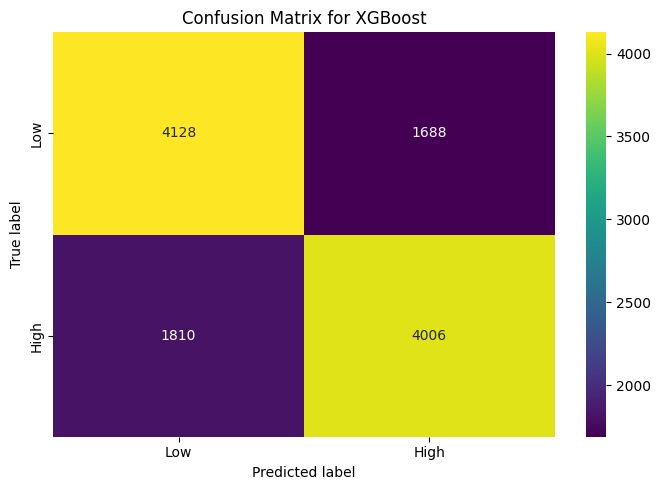

              precision    recall  f1-score   support

         Low       0.70      0.71      0.70      5816
        High       0.70      0.69      0.70      5816

    accuracy                           0.70     11632
   macro avg       0.70      0.70      0.70     11632
weighted avg       0.70      0.70      0.70     11632



In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, X_test, y_test, type_of_model):
    # Convert X_test to DMatrix for XGBoost prediction
    dtest = xgb.DMatrix(X_test)

    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(dtest)

    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title(f'Confusion Matrix for {type_of_model}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print the classification report
    print(clr)

# Example usage assuming X_val is a pandas DataFrame and val_data['popularity'] is the true labels
evaluate_model(bst, X_val, val_data['popularity'], 'XGBoost')

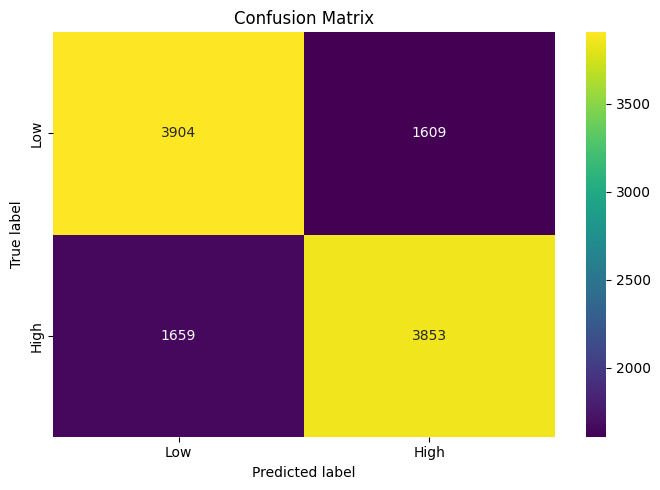

              precision    recall  f1-score   support

         Low       0.70      0.71      0.70      5513
        High       0.71      0.70      0.70      5512

    accuracy                           0.70     11025
   macro avg       0.70      0.70      0.70     11025
weighted avg       0.70      0.70      0.70     11025



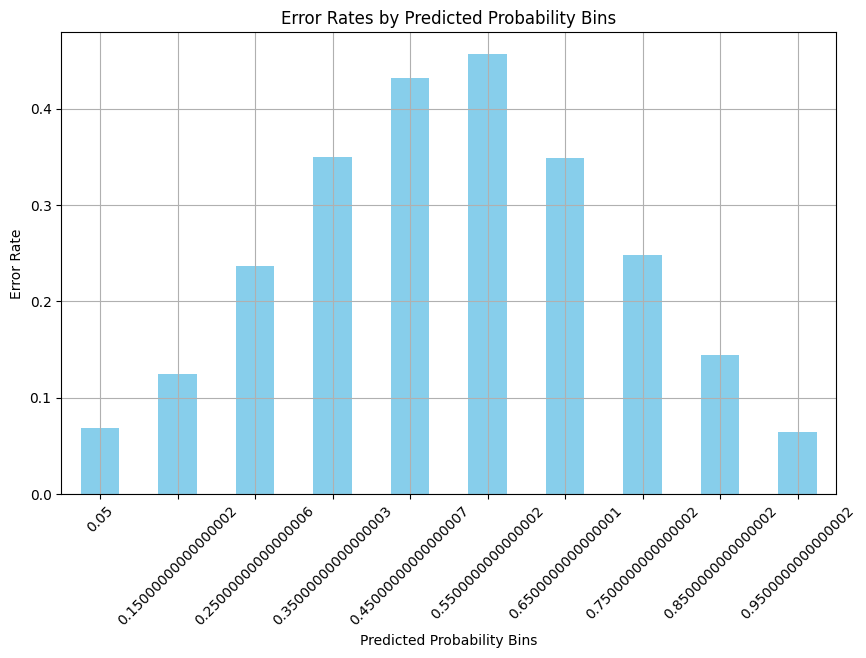

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model_and_error_rates(model, X_test, y_test):
    # Convert X_test to DMatrix for XGBoost prediction
    dtest = xgb.DMatrix(X_test)

    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(dtest)

    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # Print the classification report
    print(clr)

    # Calculate error rates by probability bins
    results = pd.DataFrame({
        'y_true': y_true,
        'y_pred_prob': y_pred_prob
    })

    results['prob_bin'] = pd.cut(results['y_pred_prob'], bins=np.arange(0, 1.1, 0.1), labels=np.arange(0.05, 1.05, 0.1))

    # Calculate error rates
    error_rates = results.groupby('prob_bin').apply(
        lambda x: np.mean(x['y_true'] != (x['y_pred_prob'] > 0.5))
    )

    # Plotting error rates by predicted probability bins
    plt.figure(figsize=(10, 6))
    error_rates.plot(kind='bar', color='skyblue')
    plt.title('Error Rates by Predicted Probability Bins')
    plt.xlabel('Predicted Probability Bins')
    plt.ylabel('Error Rate')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Example usage, assuming X_test is a pandas DataFrame and test_data['popularity'] is the true labels
evaluate_model_and_error_rates(bst, X_test, test_data['popularity'])